In [247]:
import pandas as pd
import sqlite3 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from warnings import filterwarnings

%matplotlib inline

In [248]:
filterwarnings('ignore')

In [67]:
df_title = pd.read_csv('../zippedData/imdb.title.basics.csv.gz')
df_title.shape
df_ratings = pd.read_csv('../zippedData/imdb.title.ratings.csv.gz')
df_title.shape

(146144, 6)

In [163]:
df_merge = df_title.merge(df_ratings, on='tconst', how='inner')

In [164]:
df_merge.head()  

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


I want to do some analysis on genre. However the genre is stored as an alphabetical list. I want to append EVERY genre to a super set. Once I have the set, I can turn the set into a dictionary where the keys are the dictionaries and the values are every tconst attributed to that genre.

In [71]:
# remove all none values from the genre
def remove_null_genre(df):
    return df[df.genres.notnull()]
df = remove_null_genre(df)

In [249]:
# coerce the genres to a list
df['genres'] = df.genres.apply(lambda x: x.split(','))

AttributeError: 'list' object has no attribute 'split'

In [131]:
# generate a genre set of all genres present in the df
def genre_set_list(df):
    all_genres = list(df.genres)
    return list(set([item for sublist in all_genres for item in sublist]))

genre_List=(genre_set_list(df))

In [132]:
# Create a data frame containing all of the columns and whether or not the movie has the genre

df_genre = df[['tconst', 'primary_title', 'genres']]

In [133]:
def create_boolean_series(series, genre):
        return [genre in genres for genres in series]


In [134]:
action_list = create_boolean_series(df.genres,genre_List[0])

In [138]:
def genre_list_to_series(df, L, genre):
    df[genre] = L

In [156]:
def generate_genre_dataframe(df):
    L = genre_set_list(df)
    for genre in L:
        boolean_series = create_boolean_series(df.genres,genre)
        genre_list_to_series(df, boolean_series, genre)
    return df

In [250]:
df_genre_final = generate_genre_dataframe(df_genre)

In [251]:
df_genre_final['numvotes'] = df.numvotes
df_genre_final['runtime'] = df.runtime_minutes
df_genre_final['average_rating'] =df.averagerating

In [184]:
df_genre[df_genre_final.Action == True].average_rating.mean()

5.810360618202632

In [252]:
genre_list_to_series(df_genre, create_boolean_series(df_genre.genres, genre_set_list(df_genre)[0]), genre_set_list(df_genre)[0])

In [230]:
# Generate a plot based on the features of the genre list
def genre_dict_mean(df, feature, genre_list):
    x = genre_list
    feature_dict = {}
    for genre in genre_list:
        feature_dict.update({genre:df[df[f'{genre}'] == True][f'{feature}'].mean()})
    return {k: v for k, v in sorted(feature_dict.items(), key=lambda item: item[1],reverse=True)}
    

In [232]:
foo = genre_dict_mean(df_genre, 'average_rating', genre_set_list(df_genre))

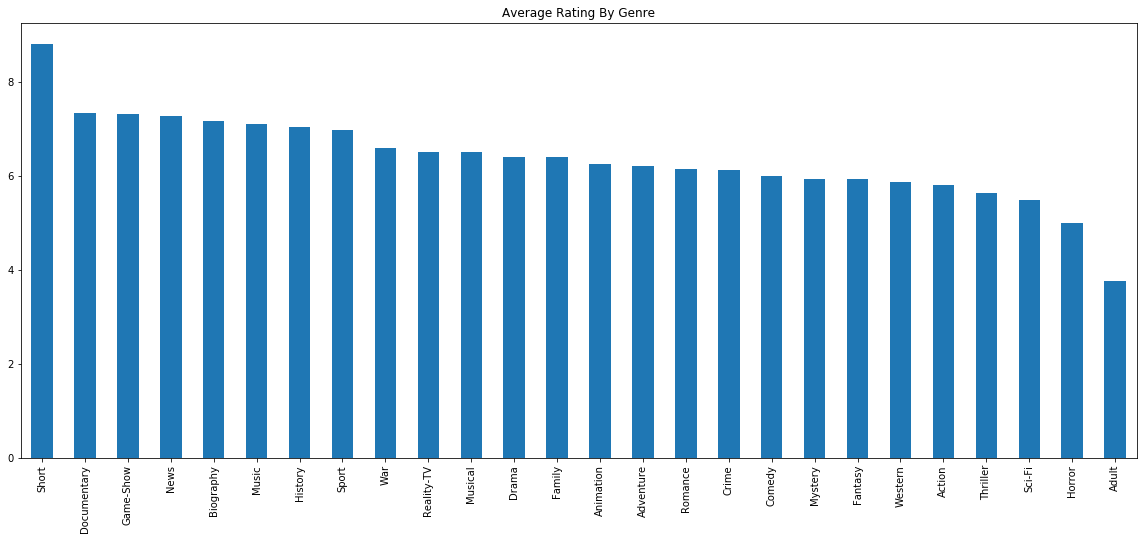

In [253]:
x = list(foo.keys())
y = list(foo.values())

df_dict = pd.DataFrame.from_dict(foo, orient='index')
df_dict.plot(kind='bar', figsize=(20,8), title='Average Rating By Genre', legend=False)
plt.savefig('foo.png')



Now that I have a set of all unique genres, I can create a dictionary

In [36]:
def frequency_dict(df, L):
    freq_dict = {}
    for genre in L:
        freq_dict.update({genre:0})
    for i in range(len(df)):
        for genre in freq_dict:
            try:
                if genre in df.iloc[i,8]:
                    freq_dict[genre] += 1
            except:
                continue
    return freq_dict

/Users/TjH/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


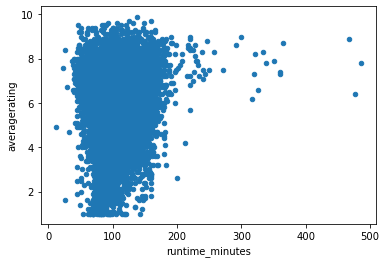

In [22]:
# plot out rating vs run times where number of votes is greater than 100 and runtime less than 600 minutes
df_runtime[(df.numvotes > 100) & (df.runtime_minutes < 600)].plot(x='runtime_minutes', y='averagerating', kind='scatter' )

It seems like there are some serious outliers in the length of the movies. Let's take a look at them. 

In [32]:
df[(df.genres == 'Documentary') & (df.numvotes > 1000)].sort_values('averagerating', ascending = False).head(5)

,tconst,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
62997,tt6679360,On vam ne Dimon,On vam ne Dimon,2017,50.0,Documentary,9.2,2721
29639,tt2869878,The Poodles: In the Flesh,The Poodles: In the Flesh,2010,152.0,Documentary,9.2,1172
56499,tt5773402,Dominion,Dominion,2018,120.0,Documentary,9.2,1096
24518,tt2412748,Saving Mes Aynak,Saving Mes Aynak,2014,60.0,Documentary,9.1,1013
840,tt10312668,Tell No One,Tylko nie mów nikomu,2019,121.0,Documentary,8.9,2111


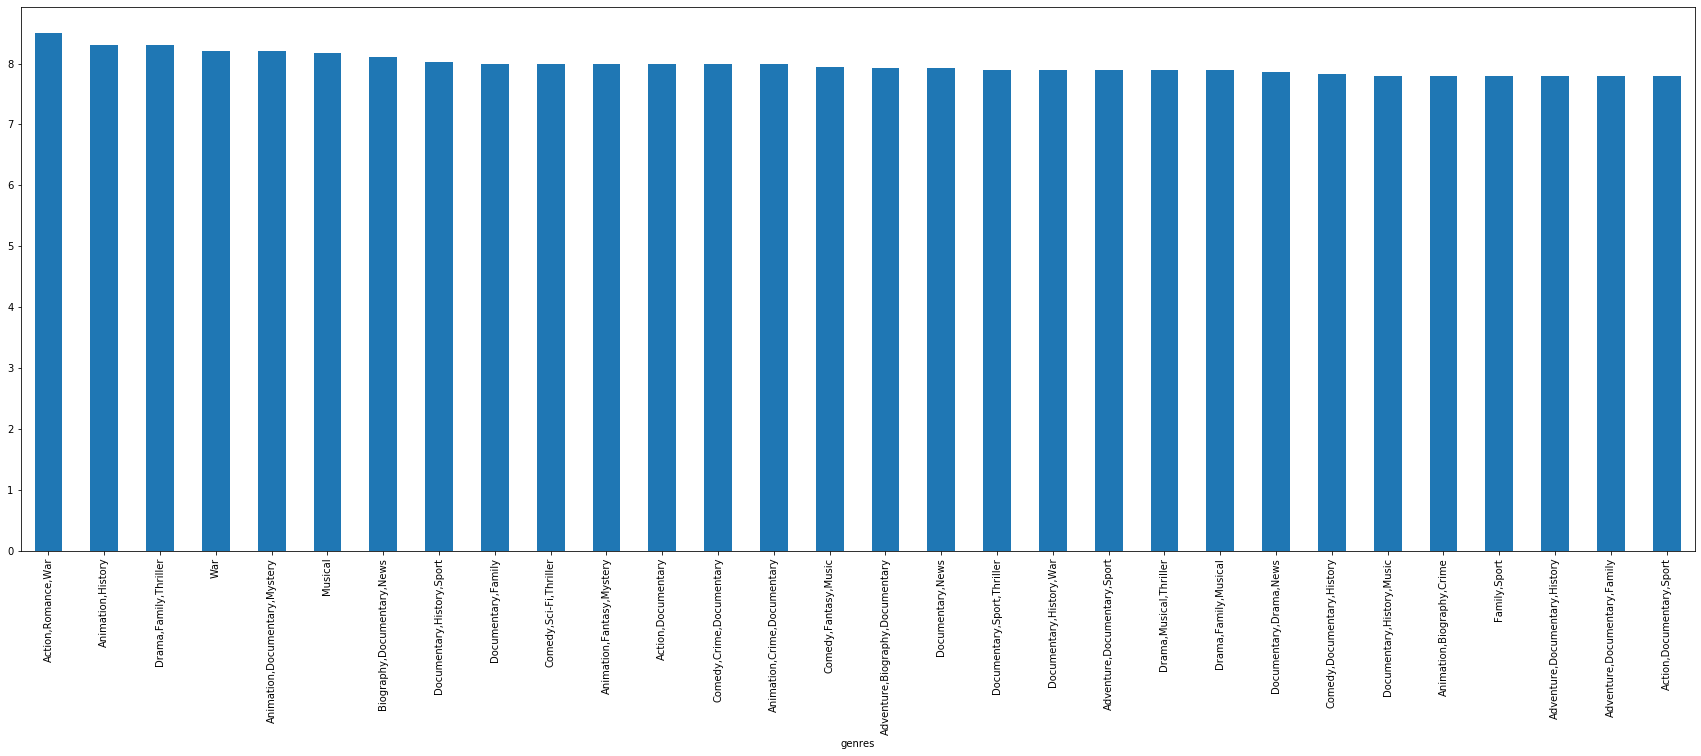

In [43]:
(df[df.numvotes > 1000].groupby(['genres']).averagerating.mean().sort_values(ascending = False))[:30].plot(kind='bar', figsize=(30,10))